<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA/blob/main/lesson_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---

# Занятие №7
# Многоклассовая классификация методами глубокого обучения
**2 апреля 2025г.**

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
# from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

from imblearn.under_sampling import RandomUnderSampler

from tqdm import tqdm
import json

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
device

device(type='cpu')

## Загрузка данных

In [3]:
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download('https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ', verify=False)

data = pd.read_parquet("./data_modes.gzip")

Downloading...
From (original): https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ
From (redirected): https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ&confirm=t&uuid=bcba50b0-a9bd-4721-ab7b-07614e79da8d
To: /content/data_modes.gzip
100%|██████████| 173M/173M [00:04<00:00, 42.9MB/s]


In [4]:
data.shape

(1082098, 56)

In [5]:
data.head()

,GTA1.DBinPU.Aldi,GTA1.DBinPU.Alvna,GTA1.DBinPU.Alzzo,GTA1.DBinPU.Bo,GTA1.DBinPU.DlPkf,GTA1.DBinPU.DlPtgft,GTA1.DBinPU.DlPvf,GTA1.DBinPU.fi,GTA1.DBinPU.hmGTD,GTA1.DBinPU.hmTG,...,heated_air,zzo_is_open,full_power_mode,partial_power_mode,increas_power_mode,decreas_power_mode,start_up_mode,shutdown_mode,stopped_state_mode,air_heating_mode
2023-02-26 06:59:50,225.550000,-4.398000,-0.082000,101.044,113.088000,33.709000,0.200000,56.615000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:00,225.610769,-4.327115,-0.089769,101.044,113.151231,33.709000,0.200000,56.615000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:10,225.436897,-4.363724,-0.091000,101.044,113.039759,33.633586,0.200207,56.516103,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:20,225.710833,-4.306625,-0.093000,101.044,113.053458,33.506500,0.200750,56.376000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:30,226.355000,-4.183118,-0.091500,101.044,113.730941,33.818529,0.200000,56.199353,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False


Чтение файла с описанием сигналов

In [7]:
# import gdown
# url = "https://drive.google.com/drive/folders/1RtrAevJUYSgTbp0YUztxEBB8_VcvjgGH?usp=drive_link"
# gdown.download_folder(url, quiet=True, verify=False)

with open(f'./option_0/description.json', 'r', encoding = "utf-8") as f:
    description = json.load(f)

Составим словарь для трактовки наименований сигналов

In [8]:
kks_to_description = {param['real_kks']: f"{param['description']}, [{param['unit']}]"
for param in description if param['real_kks'] in data.columns}

description_to_kks = { f"{param['description']}, [{param['unit']}]": param['real_kks']
for param in description if param['real_kks'] in data.columns}

## Сформируем датасет для решения задачи многоклассовой классификации

Выберем сигналы которые будем использовать. Исключим все признаки на основании которых выделялись целевые режимы.

In [9]:
feature_columns = [
    'GTA1.DBinPU.Alzzo', 'GTA1.DBinPU.Bo', 'GTA1.DBinPU.DlPkf',
    'GTA1.DBinPU.DlPtgft', 'GTA1.DBinPU.DlPvf', 'GTA1.DBinPU.fi',
    'GTA1.DBinPU.hmGTD', 'GTA1.DBinPU.hmTG', 'GTA1.DBinPU.P1mvhTG',
    'GTA1.DBinPU.Pk',
    'GTA1.DBinPU.Pmvh', 'GTA1.DBinPU.PmvhMOGTD',
    'GTA1.DBinPU.PmvhMOTG', 'GTA1.DBinPU.PmvyhMOGTD',
    'GTA1.DBinPU.PmvyhMOTG', 'GTA1.DBinPU.Prazrjag_navhode',
    'GTA1.DBinPU.Ptgpd', 'GTA1.DBinPU.Ptgvh',
    'GTA1.DBinPU.Pvh',
    'GTA1.DBinPU.Pvyhlg',
    'GTA1.DBinPU.Qtg',
    'GTA1.DBinPU.Tk',
    'GTA1.DBinPU.Tn', 'GTA1.DBinPU.Tt', 'GTA1.DBinPU.Tvh1',
    'GTA1.DBinPU.Pzad'
    ]

target_columns = [
    'full_power_mode',
    'partial_power_mode',
    'increas_power_mode',
    'decreas_power_mode',
    'start_up_mode',
    'shutdown_mode',
    'stopped_state_mode'
]

В данных прсутствуют примеры которые одновременно относятся к нескольким режимам. Класс таких задач называется **многоклассовой классификацией с пересечением классов** (*multi-label classification*). Нам необходимо избавиться от тких примеров.

In [10]:
data[data[target_columns].sum(axis=1) > 1][target_columns]

,full_power_mode,partial_power_mode,increas_power_mode,decreas_power_mode,start_up_mode,shutdown_mode,stopped_state_mode
2023-04-07 09:20:00,False,False,False,True,True,False,False
2023-04-07 09:20:10,False,False,False,True,True,False,False
2023-04-07 09:20:20,False,False,False,True,True,False,False
2023-04-07 09:20:30,False,False,False,True,True,False,False
2023-04-07 09:20:40,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...
2023-07-07 19:53:40,False,False,False,False,True,True,False
2023-07-07 19:53:50,False,False,False,False,True,True,False
2023-07-07 19:59:20,False,False,False,False,True,True,False
2023-07-07 20:06:00,False,False,False,False,True,True,False


In [11]:
data.loc[data['adjustment_range'], ['start_up_mode']] = False
data.loc[data['adjustment_range'], ['shutdown_mode']] = False
data.loc[data['increase_power'], ['shutdown_mode']] = False
data.loc[data['decreas_power_mode'], ['start_up_mode']] = False

In [12]:
data[data[target_columns].sum(axis=1) > 1][target_columns]

,full_power_mode,partial_power_mode,increas_power_mode,decreas_power_mode,start_up_mode,shutdown_mode,stopped_state_mode
2023-04-07 09:20:40,False,False,False,False,True,True,False
2023-04-12 08:21:30,False,False,False,False,True,True,False
2023-04-21 07:21:50,False,False,False,False,True,True,False
2023-04-21 07:22:00,False,False,False,False,True,True,False
2023-04-21 07:36:40,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...
2023-07-07 19:52:00,False,False,False,False,True,False,True
2023-07-07 19:53:20,False,False,False,False,True,True,False
2023-07-07 19:53:30,False,False,False,False,True,True,False
2023-07-07 19:53:40,False,False,False,False,True,True,False


In [13]:
data = data.loc[data[target_columns].sum(axis=1) == 1]

Создадим датаврейм с признаками и целевыми значения

In [14]:
X = data.loc[:,feature_columns]

In [15]:
data['target'] = data[target_columns].idxmax(axis=1)
y = data.loc[:, ['target']]

In [16]:
y.value_counts()

,count
target,
full_power_mode,1044257
stopped_state_mode,26614
partial_power_mode,9547
shutdown_mode,344
increas_power_mode,109
decreas_power_mode,103
start_up_mode,98


### Деление на тестовую и тренировочную выборки

In [17]:
from sklearn.model_selection import train_test_split
# Разделяем с учетом дисбаланса классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
y_train.value_counts()

,count
target,
full_power_mode,835405
stopped_state_mode,21291
partial_power_mode,7638
shutdown_mode,275
increas_power_mode,87
decreas_power_mode,82
start_up_mode,79


In [19]:
y_test.value_counts()

,count
target,
full_power_mode,208852
stopped_state_mode,5323
partial_power_mode,1909
shutdown_mode,69
increas_power_mode,22
decreas_power_mode,21
start_up_mode,19


Видно, что датасет сильно несбалансирован.
При такой несбалансорованности модели будут плохо обучаеться на редких классах.
Алгоритм может игнорировать малочисленные классы, потому что минимизация ошибки будет достигаться за счет предсказания большинства.
Например, если модель всегда предсказывает full_power_mode, она все равно получит высокую точность.

### Балансировка данных
**Oversampling (увеличение малых классов)**  
   - Повторение существующих редких примеров или их генерация.  
   - **SMOTE (Synthetic Minority Over-sampling Technique)** – создает новые точки малочисленных классов, используя линейные комбинации соседних точек.  

**Undersampling (уменьшение частых классов)**  
- Удаление случайных примеров из большинства классов.  

**Комбинация Oversampling + Undersampling**  
   - Часто лучше сначала **уменьшить большие**, а затем **увеличить малые классы**.  

#### Undersampling

In [20]:
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy = {
    "full_power_mode": 1000,
    "stopped_state_mode": 1000,
    "partial_power_mode": 1000
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [21]:
y_train_resampled.value_counts()

,count
target,
full_power_mode,1000
stopped_state_mode,1000
partial_power_mode,1000
shutdown_mode,275
increas_power_mode,87
decreas_power_mode,82
start_up_mode,79


In [22]:
sampling_strategy = {
    "full_power_mode": 100,
    "stopped_state_mode": 100,
    "partial_power_mode": 100
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_test_resampled, y_test_resampled = rus.fit_resample(X_test, y_test)

In [23]:
y_test_resampled.value_counts()

,count
target,
full_power_mode,100
stopped_state_mode,100
partial_power_mode,100
shutdown_mode,69
increas_power_mode,22
decreas_power_mode,21
start_up_mode,19


#### Oversampling

In [24]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_resampled, y_train_resampled)

In [25]:
y_train_resampled.value_counts()

,count
target,
decreas_power_mode,1000
full_power_mode,1000
increas_power_mode,1000
partial_power_mode,1000
shutdown_mode,1000
start_up_mode,1000
stopped_state_mode,1000


### Нормализация или стандартизация данных

In [26]:
# scaler = preprocessing.MinMaxScaler() # нормализация данных
scaler = preprocessing.StandardScaler() # стандартизация данных

X_train_resampled_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_resampled),
    columns=X_train_resampled.columns,
    index=X_train_resampled.index)

X_test_resampled_scaled = pd.DataFrame(
    scaler.transform(X_test_resampled),
    columns=X_test_resampled.columns,
    index=X_test_resampled.index)

X_train_resampled_scaled.describe()

,GTA1.DBinPU.Alzzo,GTA1.DBinPU.Bo,GTA1.DBinPU.DlPkf,GTA1.DBinPU.DlPtgft,GTA1.DBinPU.DlPvf,GTA1.DBinPU.fi,GTA1.DBinPU.hmGTD,GTA1.DBinPU.hmTG,GTA1.DBinPU.P1mvhTG,GTA1.DBinPU.Pk,...,GTA1.DBinPU.Ptgpd,GTA1.DBinPU.Ptgvh,GTA1.DBinPU.Pvh,GTA1.DBinPU.Pvyhlg,GTA1.DBinPU.Qtg,GTA1.DBinPU.Tk,GTA1.DBinPU.Tn,GTA1.DBinPU.Tt,GTA1.DBinPU.Tvh1,GTA1.DBinPU.Pzad
count,7000.000000,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7000.000000,...,7000.000000,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03
mean,0.000000,5.166661e-15,3.248195e-17,1.624098e-16,-9.744586e-17,-1.786507e-16,9.825791e-16,-6.516692e-16,-1.624098e-16,0.000000,...,0.000000,1.136868e-16,4.450028e-15,1.624098e-16,-1.299278e-16,-9.744586e-17,2.395544e-16,1.624098e-17,-9.744586e-17,6.496391e-17
std,1.000071,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071,...,1.000071,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-0.150836,-3.483637e+00,-1.364960e+00,-1.256967e+00,-1.312397e+00,-1.717966e+00,-1.661042e+00,-1.841880e+00,-2.448871e+00,-1.277630,...,-1.737767,-1.753303e+00,-2.020892e+00,-1.090359e+00,-1.284222e+00,-1.459861e+00,-3.269862e+00,-1.776393e+00,-3.372734e+00,-1.133596e+00
25%,-0.139177,-8.320416e-01,-1.214821e+00,-1.067208e+00,-1.164517e+00,-7.619812e-01,-6.895259e-01,-7.257695e-01,1.504733e-01,-1.237118,...,-0.552732,1.445738e-01,-1.025929e+00,-9.894009e-01,-1.279066e+00,-1.240542e+00,-7.571418e-01,-5.988512e-01,-6.362144e-01,-1.133596e+00
50%,-0.136846,1.720278e-01,4.018414e-02,-8.218985e-02,1.917602e-01,-1.836266e-01,-9.987480e-02,-2.697954e-02,4.192892e-01,0.411681,...,0.516404,5.415910e-01,-3.709982e-03,-2.735612e-01,2.574841e-01,5.041851e-01,-9.225458e-02,4.288653e-01,-8.995334e-02,1.910320e-01
75%,-0.133249,7.082264e-01,8.886384e-01,9.928706e-01,9.334934e-01,7.206879e-01,7.891631e-01,6.433743e-01,5.211870e-01,1.011002,...,0.642990,6.113761e-01,9.662202e-01,1.097918e+00,9.425020e-01,8.798707e-01,6.832665e-01,6.758578e-01,8.404764e-01,1.119746e+00
max,7.499190,2.809972e+00,1.792953e+00,1.820303e+00,1.594687e+00,2.582471e+00,2.600627e+00,2.442016e+00,9.840554e-01,1.156943,...,0.777035,7.473262e-01,1.344548e+00,1.718766e+00,1.489107e+00,1.259341e+00,2.454681e+00,1.160885e+00,2.423393e+00,1.199667e+00


### LabelEncoding

Закодируем текстовые метки классов в числовые значения

In [27]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [28]:
y_train_resampled_encoded = encoder.fit_transform(y_train_resampled.values[:,0])
y_test_resampled_encoded = encoder.transform(y_test_resampled.values[:,0])

In [29]:
y_test_resampled_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

### Dataset и DataLoader

In [31]:
from torch.utils.data import Dataset

class ModeDataset(Dataset):
    def __init__(self):
        self.x = torch.tensor(X_train_resampled_scaled.values, dtype=torch.float32)
        self.y = torch.tensor(y_train_resampled_encoded, dtype=torch.long)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

In [32]:
dataset = ModeDataset()

print(len(dataset))
print("Sample number 0 : ", dataset[0])
print("Target 0 : ", dataset[0][1])

7000
Sample number 0 :  (tensor([-0.1405,  0.7128,  0.4011,  0.2838,  0.4300, -0.9146, -1.6450, -1.8370,
         0.2338,  0.6526,  0.6278, -0.6797,  0.3748,  0.0000,  0.0000,  0.4938,
         0.5924,  0.5807, -0.3210,  0.6598,  0.6850,  0.6802, -0.1415,  0.3938,
        -0.3367,  0.3463]), tensor(0))
Target 0 :  tensor(0)


In [33]:
from torch.utils.data import DataLoader

BATCH_SIZE = 256

INPUT_SIZE = len(feature_columns)
OUTPUT_SIZE = len(target_columns)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Функция для обучения модели

**Что такое Learning Rate?**  

**Learning Rate (скорость обучения, $\eta$)** – это гиперпараметр, определяющий, **насколько сильно обновляются веса нейросети на каждом шаге градиентного спуска**.  

Если **learning rate слишком большой** → модель может "перепрыгивать" оптимальные веса и не сойтись.  
Если **learning rate слишком маленький** → обучение будет слишком медленным или застрянет в локальном минимуме.  

Пример обновления весов с learning rate \(\eta\):  
$$w = w - \eta \cdot \frac{\partial L}{\partial w}$$

где:  
- \( w \) — веса модели,  
- \( \frac{\partial L}{\partial w} \) — градиент функции ошибки \( L \),  
- \( \eta \) — learning rate.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRaK3GNwACWpqsTkfBvKdB9osthN7aWVE1ahw&s" alt="rf image" width="600"  align="center"/>

**Зачем нужен scheduler?**  

Обычно в начале обучения выгодно использовать **большой** `learning rate` (чтобы быстро находить хорошие параметры), а к концу — **уменьшать** его, чтобы модель точнее подстраивалась.  

**Scheduler** – это инструмент, который автоматически изменяет learning rate **по заданному правилу**. Это помогает избежать проблем с застреванием или нестабильностью обучения.  



**Популярные стратегии изменения Learning Rate (Schedulers)**  
🔹 **StepLR** – уменьшает `lr` через заданное количество эпох.  
🔹 **ExponentialLR** – уменьшает `lr` экспоненциально.  
🔹 **ReduceLROnPlateau** – уменьшает `lr`, если метрика не улучшается.  
🔹 **CosineAnnealingLR** – снижает `lr` по косинусной функции, часто используется в глубоких сетях.  

Использование **learning rate scheduler'а** позволяет сделать обучение модели **более эффективным** и **устойчивым**.

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):

    loaders = {"train": train_loader, "valid": valid_loader}

    epochs = num_epochs

    lr = []
    losses = {"train": [], "valid": []}
    for epoch in tqdm(range(epochs)):

        for k, dataloader in loaders.items():
            running_loss = []

            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                loss = criterion(outp, y_batch)
                running_loss.append(loss.item())

                if k == "train":
                    loss.backward()
                    optimizer.step()

            if k == "train":
                lr.append(scheduler.optimizer.param_groups[0]['lr'])
            losses[k].append(np.array(running_loss).mean())

        scheduler.step(losses["train"][-1])

    return model, losses, lr

Инициализируем переменные для дальнейшего сравнения моделей

## Полносвязная нейронная сеть (многослойный персептрон)
## Обучение моделей

In [ ]:
accuracy_classifier = {}
precision_classifier = {}
recall_classifier = {}
f1_classifier = {}

### Модель №1

Простая полносвязная сеть

In [35]:
class FCNN(nn.Module):
  def __init__(
      self, hidden_size=512, hidden_num=1):
    super(FCNN, self).__init__()

    # Входной слой
    self.input_layer = nn.Sequential(
        nn.Linear(INPUT_SIZE, hidden_size),
        nn.ReLU(),
    )

    # Скрытые слои
    self.hidden_layers = nn.ModuleList()
    for _ in range(hidden_num):
        self.hidden_layers.append(
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
            )
        )

    # Выходной слой
    self.output_layer = nn.Linear(hidden_size, OUTPUT_SIZE)

  def forward(self, x):
    x = self.input_layer(x)

    for layer in self.hidden_layers:
        x = layer(x)

    x = self.output_layer(x)
    return x


#### Обучение модели

**CrossEntropyLoss**  

`CrossEntropyLoss` – это функция потерь, которая используется в задачах **многоклассовой классификации**. Она измеряет, насколько предсказанное распределение вероятностей отличается от истинных классов.  

**Формула CrossEntropyLoss:**  
Для одного объекта:
$$\text{Loss} = - \sum_{i=1}^{C} y_i \log(\hat{p}_i)$$
где:  
- $ C $ – количество классов,  
- $ y_i $ – индикатор (0 или 1), показывающий правильный класс,  
- $ \hat{p}_i $ – предсказанная вероятность для класса $ i $.  

Если правильный класс – это $ k $, то формула упрощается до:  
$$\text{Loss} = -\log(\hat{p}_k)$$
Это значит, что штрафуется именно вероятность правильного класса – чем она ниже, тем выше ошибка.  

---

**Особенности:**
1. **Работает с "сырыми" логитами (до softmax).** Внутри себя `CrossEntropyLoss` сама применяет `softmax`, так что передавать уже нормализованные вероятности **не нужно**.  
2. **Подходит для one-hot меток, но чаще используется с индексами классов.**  
3. **Используется в многоклассовой классификации** (если у примера один правильный класс).

---

**Softmax**  

`Softmax` – это функция, которая **преобразует логиты** (сырые выходы нейросети) в **вероятности**, так чтобы их сумма была **равна 1**. Она часто используется в задачах многоклассовой классификации.  

**Формула Softmax:**  
Для каждого выхода $ z_i $ нейросети:  
$$\hat{p}_i = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$$  
где:  
- $ \hat{p}_i $ – вероятность, что объект принадлежит классу $ i $,  
- $ C $ – количество классов,  
- $ z_i $ – логит для класса $ i $,  
- $ e^{z_i} $ – экспоненциальное преобразование логита (делает все значения положительными).  

**Что делает Softmax?**
1. **Нормализует выходы нейросети** – переводит их в диапазон $ [0,1] $.  
2. **Гарантирует, что сумма всех выходов = 1** (их можно интерпретировать как вероятности).  
3. **Подчеркивает разницу между выходами** – чем больше разница между логитами, тем сильнее выделяется наиболее вероятный класс.  

In [36]:
FCNN_16_2 = FCNN(16, 2).to(device)
# FCNN_64_2._initialize_weights()

# criterion = nn.MSELoss()

# class_weights = torch.tensor([2.0, 2.0, 1.0]).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(FCNN_16_2.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=30, threshold=0.0001)

FCNN_16_2, losses_FCNN_16_2, lr_FCNN_16_2 = train_model(
    FCNN_16_2, criterion, optimizer,
    scheduler, num_epochs=200)

100%|██████████| 200/200 [00:30<00:00,  6.59it/s]


Посмотрим на график изменения среднего на эпохе значения функции потерь.

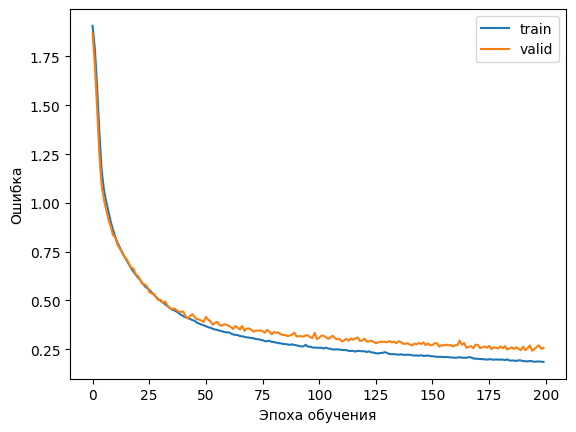

In [37]:
plt.plot(losses_FCNN_16_2['train'], label='train');
plt.plot(losses_FCNN_16_2['valid'], label='valid');
plt.legend();
plt.ylabel("Ошибка");
plt.xlabel("Эпоха обучения");

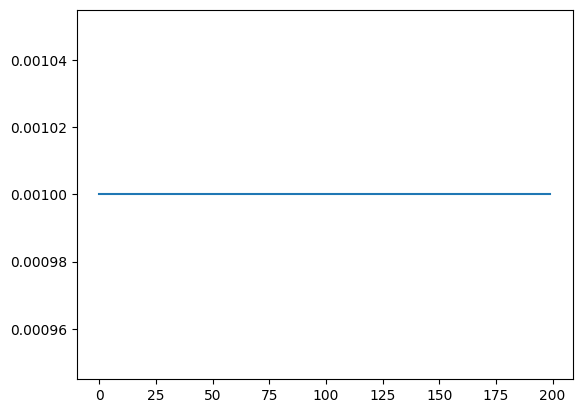

In [38]:
plt.plot(lr_FCNN_16_2);

In [39]:
print('Loss в конце обучения')
print(f'На обучающей выборке: {losses_FCNN_16_2["train"][-1]:.5f}')
print(f'На валидационной выборке: {losses_FCNN_16_2["valid"][-1]:.5f}')

Loss в конце обучения
На обучающей выборке: 0.18549
На валидационной выборке: 0.25727


Посмотрим предсказания на нескольких случайных примерах.


In [40]:
some_indexes = y_test_resampled.groupby('target').sample(n=1, random_state=42).index
X_some_modes = X_test_resampled_scaled.loc[some_indexes]
y_some_modes = y_test_resampled.loc[some_indexes]

FCNN_16_2.to("cpu")
FCNN_16_2.eval()
logits = FCNN_16_2(torch.tensor(X_some_modes.values, dtype=torch.float32))

predicted_classes = torch.argmax(logits, dim=1)

for target, predict in zip(y_some_modes.values, predicted_classes.detach().numpy()):
    print(f"Истина - {target[0]} >>> {encoder.inverse_transform([predict])[0]} - предсказание")

Истина - decreas_power_mode >>> decreas_power_mode - предсказание
Истина - full_power_mode >>> full_power_mode - предсказание
Истина - increas_power_mode >>> increas_power_mode - предсказание
Истина - partial_power_mode >>> partial_power_mode - предсказание
Истина - shutdown_mode >>> start_up_mode - предсказание
Истина - start_up_mode >>> shutdown_mode - предсказание
Истина - stopped_state_mode >>> stopped_state_mode - предсказание


Посмотрим на уверенность модели в своих предсказаниях.

In [41]:
pd.DataFrame(torch.softmax(logits, dim=1).detach().numpy(), columns=encoder.classes_).applymap(lambda x: f'{x:.3f}')

,decreas_power_mode,full_power_mode,increas_power_mode,partial_power_mode,shutdown_mode,start_up_mode,stopped_state_mode
0,0.865,0.135,0.000,0.000,0.000,0.000,0.000
1,0.044,0.952,0.004,0.000,0.000,0.000,0.000
2,0.003,0.000,0.991,0.006,0.000,0.000,0.000
3,0.001,0.000,0.019,0.980,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.436,0.564,0.000
5,0.000,0.000,0.000,0.000,0.509,0.491,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,1.000


#### Анализ качества модели

In [42]:
FCNN_16_2.eval()
logits =  FCNN_16_2(torch.tensor(X_test_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_test_pred_FCNN_16_2 = encoder.inverse_transform(predicted_classes)

**Матрица неточностей**

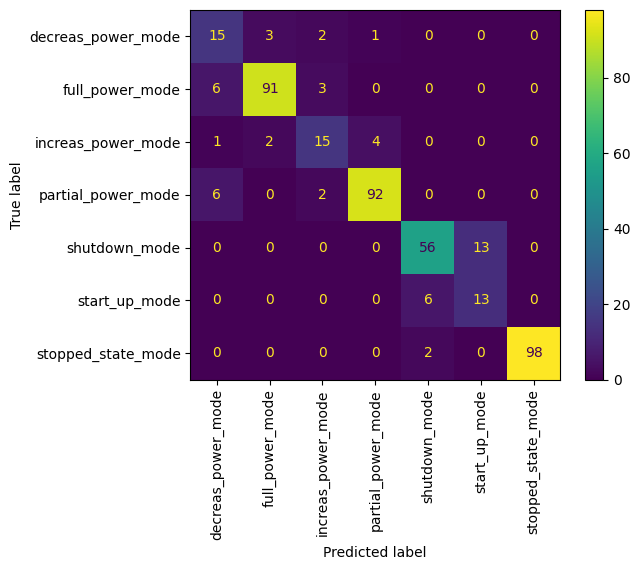

In [43]:
conf_mat = confusion_matrix(y_test_resampled, y_test_pred_FCNN_16_2)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

**Accuracy**

In [44]:
accuracy_classifier['FCNN_16_2'] = accuracy_score(y_test_resampled, y_test_pred_FCNN_16_2)

**Precision и recall**

In [45]:
precision_classifier['FCNN_16_2'] = precision_score(y_test_resampled, y_test_pred_FCNN_16_2, average='macro', zero_division = np.nan)
recall_classifier['FCNN_16_2'] = recall_score(y_test_resampled, y_test_pred_FCNN_16_2, average='macro', zero_division = np.nan)

**F1**

In [46]:
f1_classifier['FCNN_16_2'] = f1_score(y_test_resampled, y_test_pred_FCNN_16_2, average='macro', zero_division = np.nan)

**Значения метрик**

In [47]:
print(f"accuracy - {accuracy_classifier['FCNN_16_2']*100:0.2f}%")
print(f"precision - {precision_classifier['FCNN_16_2']*100:0.2f}%")
print(f"recall - {recall_classifier['FCNN_16_2']*100:0.2f}%")
print(f"F1 - {f1_classifier['FCNN_16_2']*100:0.2f}%")

accuracy - 88.17%
precision - 78.41%
recall - 81.46%
F1 - 79.52%


### Модель №2
Увеличим число скрытых слоев в модели
#### Обучение модели

In [48]:
FCNN_16_4 = FCNN(16, 4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(FCNN_16_4.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=30, threshold=0.0001)

FCNN_16_4, losses_FCNN_16_4, lr_FCNN_16_4 = train_model(
    FCNN_16_4, criterion, optimizer,
    scheduler, num_epochs=200)

100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Посмотрим на график изменения среднего на эпохе значения функции потерь.

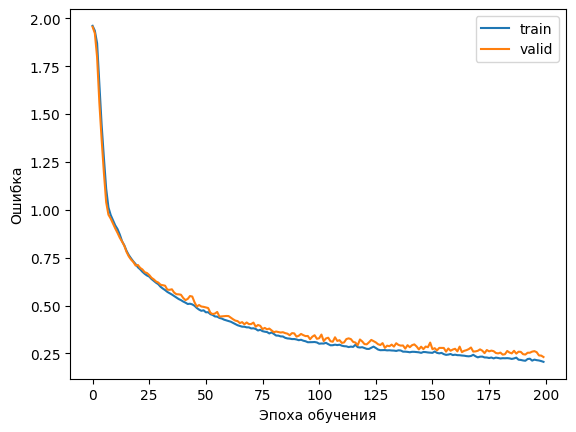

In [49]:
plt.plot(losses_FCNN_16_4['train'], label='train');
plt.plot(losses_FCNN_16_4['valid'], label='valid');
plt.legend();
plt.ylabel("Ошибка");
plt.xlabel("Эпоха обучения");

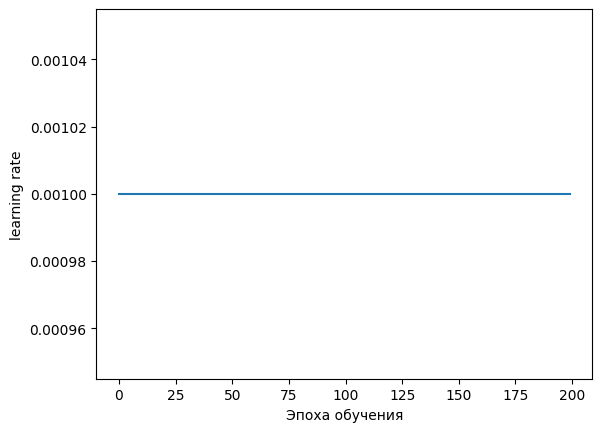

In [50]:
plt.plot(lr_FCNN_16_4);
plt.ylabel("learning rate");
plt.xlabel("Эпоха обучения");

In [51]:
print('Loss в конце обучения')
print(f'На обучающей выборке: {losses_FCNN_16_4["train"][-1]:.5f}')
print(f'На валидационной выборке: {losses_FCNN_16_4["valid"][-1]:.5f}')

Loss в конце обучения
На обучающей выборке: 0.20598
На валидационной выборке: 0.23109


In [52]:
some_indexes = y_test_resampled.groupby('target').sample(n=1, random_state=42).index
X_some_modes = X_test_resampled_scaled.loc[some_indexes]
y_some_modes = y_test_resampled.loc[some_indexes]

FCNN_16_4.to("cpu")
FCNN_16_4.eval()
logits = FCNN_16_4(torch.tensor(X_some_modes.values, dtype=torch.float32))
predicted_classes = torch.argmax(logits, dim=1)

for target, predict in zip(y_some_modes.values, predicted_classes.detach().numpy()):
    print(f"Истина - {target[0]} >>> {encoder.inverse_transform([predict])[0]} - предсказание")

Истина - decreas_power_mode >>> decreas_power_mode - предсказание
Истина - full_power_mode >>> full_power_mode - предсказание
Истина - increas_power_mode >>> decreas_power_mode - предсказание
Истина - partial_power_mode >>> partial_power_mode - предсказание
Истина - shutdown_mode >>> start_up_mode - предсказание
Истина - start_up_mode >>> start_up_mode - предсказание
Истина - stopped_state_mode >>> stopped_state_mode - предсказание


Посмотрим на уверенность модели в своих предсказаниях.

In [53]:
pd.DataFrame(torch.softmax(logits, dim=1).detach().numpy(), columns=encoder.classes_).applymap(lambda x: f'{x:.3f}')

,decreas_power_mode,full_power_mode,increas_power_mode,partial_power_mode,shutdown_mode,start_up_mode,stopped_state_mode
0,0.884,0.075,0.035,0.006,0.000,0.000,0.000
1,0.015,0.946,0.039,0.001,0.000,0.000,0.000
2,0.608,0.001,0.361,0.030,0.000,0.000,0.000
3,0.006,0.001,0.000,0.993,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.264,0.736,0.000
5,0.000,0.000,0.000,0.000,0.242,0.758,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,1.000


#### Анализ качества модели

In [54]:
FCNN_16_4.eval()
logits =  FCNN_16_4(torch.tensor(X_test_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_test_pred_FCNN_16_4 = encoder.inverse_transform(predicted_classes)

**Матрица неточностей**

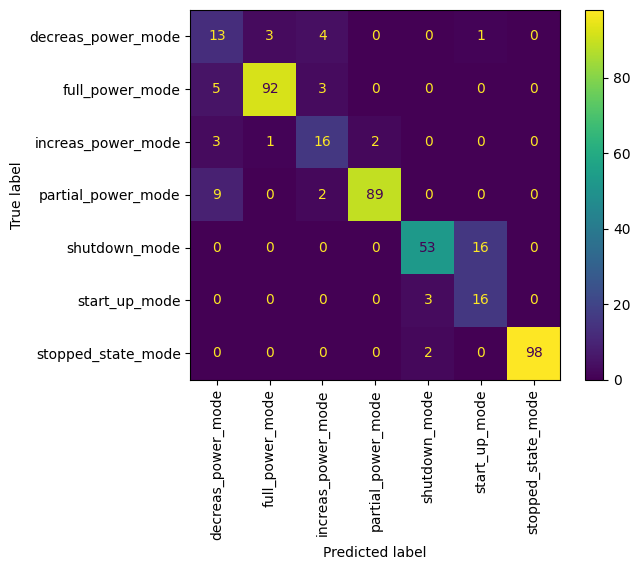

In [55]:
conf_mat = confusion_matrix(y_test_resampled, y_test_pred_FCNN_16_4)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

**Accuracy**

In [56]:
accuracy_classifier['FCNN_16_4'] = accuracy_score(y_test_resampled, y_test_pred_FCNN_16_4)

**Precision и recall**

In [57]:
precision_classifier['FCNN_16_4'] = precision_score(y_test_resampled, y_test_pred_FCNN_16_4, average='macro', zero_division = np.nan)
recall_classifier['FCNN_16_4'] = recall_score(y_test_resampled, y_test_pred_FCNN_16_4, average='macro', zero_division = np.nan)

**F1**

In [58]:
f1_classifier['FCNN_16_4'] = f1_score(y_test_resampled, y_test_pred_FCNN_16_4, average='macro', zero_division = np.nan)

**Значения метрик**

In [59]:
print(f"accuracy - {accuracy_classifier['FCNN_16_4']*100:0.2f}%")
print(f"precision - {precision_classifier['FCNN_16_4']*100:0.2f}%")
print(f"recall - {recall_classifier['FCNN_16_4']*100:0.2f}%")
print(f"F1 - {f1_classifier['FCNN_16_4']*100:0.2f}%")

accuracy - 87.47%
precision - 77.26%
recall - 82.09%
F1 - 78.59%


### Модель №3
Увеличим размер скрытых слоев в модели
### Обучение модели

In [107]:
FCNN_32_4 = FCNN(32, 4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(FCNN_32_4.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=30, threshold=0.0001)

FCNN_32_4, losses_FCNN_32_4, lr_FCNN_32_4 = train_model(
    FCNN_32_4, criterion, optimizer,
    scheduler, num_epochs=1000)

 17%|█▋        | 174/1000 [00:37<02:57,  4.66it/s]


KeyboardInterrupt: 

Посмотрим на график изменения среднего на эпохе значения функции потерь.

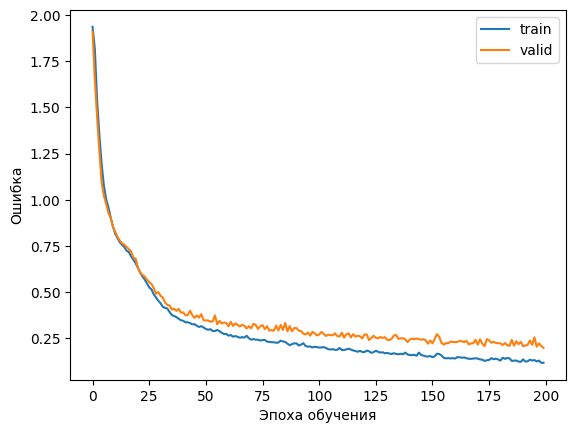

In [61]:
plt.plot(losses_FCNN_32_4['train'], label='train');
plt.plot(losses_FCNN_32_4['valid'], label='valid');
plt.legend();
plt.ylabel("Ошибка");
plt.xlabel("Эпоха обучения");

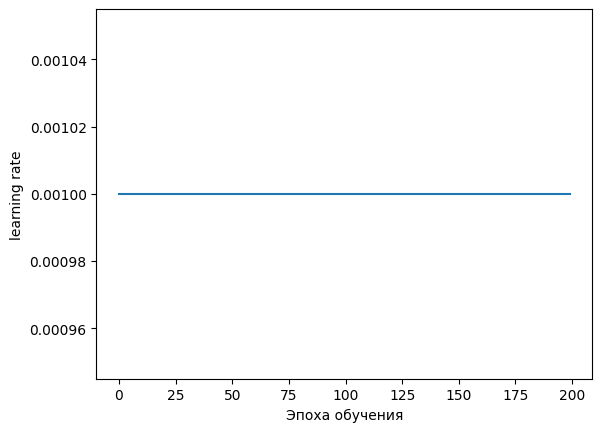

In [62]:
plt.plot(lr_FCNN_32_4);
plt.ylabel("learning rate");
plt.xlabel("Эпоха обучения");

In [63]:
print('Loss в конце обучения')
print(f'На обучающей выборке: {losses_FCNN_32_4["train"][-1]:.5f}')
print(f'На валидационной выборке: {losses_FCNN_32_4["valid"][-1]:.5f}')

Loss в конце обучения
На обучающей выборке: 0.11682
На валидационной выборке: 0.19803


Посмотрим предсказания на нескольких случайных примерах.

In [64]:
some_indexes = y_test_resampled.groupby('target').sample(n=1, random_state=42).index
X_some_modes = X_test_resampled_scaled.loc[some_indexes]
y_some_modes = y_test_resampled.loc[some_indexes]

FCNN_32_4.to("cpu")
FCNN_32_4.eval()
logits = FCNN_32_4(torch.tensor(X_some_modes.values, dtype=torch.float32))
predicted_classes = torch.argmax(logits, dim=1)

for target, predict in zip(y_some_modes.values, predicted_classes.detach().numpy()):
    print(f"Истина - {target[0]} >>> {encoder.inverse_transform([predict])[0]} - предсказание")

Истина - decreas_power_mode >>> decreas_power_mode - предсказание
Истина - full_power_mode >>> full_power_mode - предсказание
Истина - increas_power_mode >>> increas_power_mode - предсказание
Истина - partial_power_mode >>> partial_power_mode - предсказание
Истина - shutdown_mode >>> shutdown_mode - предсказание
Истина - start_up_mode >>> start_up_mode - предсказание
Истина - stopped_state_mode >>> stopped_state_mode - предсказание


Посмотрим на уверенность модели в своих предсказаниях.

In [65]:
pd.DataFrame(torch.softmax(logits, dim=1).detach().numpy(), columns=encoder.classes_).applymap(lambda x: f'{x:.3f}')

,decreas_power_mode,full_power_mode,increas_power_mode,partial_power_mode,shutdown_mode,start_up_mode,stopped_state_mode
0,0.999,0.001,0.000,0.000,0.000,0.000,0.000
1,0.005,0.995,0.000,0.000,0.000,0.000,0.000
2,0.052,0.003,0.897,0.048,0.000,0.000,0.000
3,0.012,0.001,0.000,0.987,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.562,0.438,0.000
5,0.000,0.000,0.000,0.000,0.312,0.688,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,1.000


#### Анализ качества модели

In [66]:
FCNN_32_4.eval()
logits =  FCNN_32_4(torch.tensor(X_test_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_test_pred_FCNN_32_4 = encoder.inverse_transform(predicted_classes)

**Матрица неточностей**

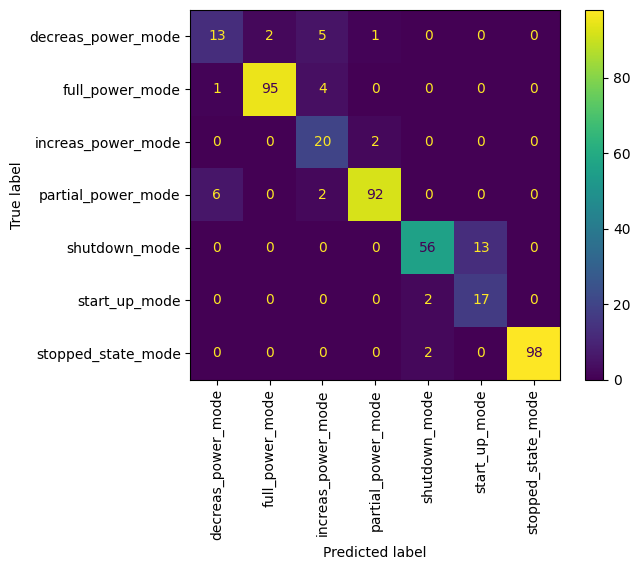

In [67]:
conf_mat = confusion_matrix(y_test_resampled, y_test_pred_FCNN_32_4)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

**Accuracy**

In [68]:
accuracy_classifier['FCNN_32_4'] = accuracy_score(y_test_resampled, y_test_pred_FCNN_32_4)

**Precision и recall**

In [69]:
precision_classifier['FCNN_32_4'] = precision_score(y_test_resampled, y_test_pred_FCNN_32_4, average='macro', zero_division = np.nan)
recall_classifier['FCNN_32_4'] = recall_score(y_test_resampled, y_test_pred_FCNN_32_4, average='macro', zero_division = np.nan)

**F1**

In [70]:
f1_classifier['FCNN_32_4'] = f1_score(y_test_resampled, y_test_pred_FCNN_32_4, average='macro', zero_division = np.nan)

**Значения метрик**

In [71]:
print(f"accuracy - {accuracy_classifier['FCNN_32_4']*100:0.2f}%")
print(f"precision - {precision_classifier['FCNN_32_4']*100:0.2f}%")
print(f"recall - {recall_classifier['FCNN_32_4']*100:0.2f}%")
print(f"F1 - {f1_classifier['FCNN_32_4']*100:0.2f}%")

accuracy - 90.72%
precision - 82.04%
recall - 86.92%
F1 - 83.56%


### Модель №4

**Batch Normalization (BatchNorm)**  

**Batch Normalization (нормализация по батчам, BatchNorm)** – это метод, который стабилизирует и ускоряет обучение нейросетей, **нормализуя входные данные на каждом слое**.  

**Главная идея:**  
Каждый слой нейросети получает входные данные, которые могут сильно различаться по масштабу. BatchNorm **выравнивает их распределение**, приводя к более стабильному градиентному спуску.  

---

**Зачем нужен BatchNorm?**  
**Стабилизирует градиентный спуск** (предотвращает "взрыв" или "затухание" градиентов).  
**Позволяет использовать более высокий `learning rate`**, ускоряя обучение.  
**Уменьшает зависимость от инициализации весов**.  
**Добавляет небольшой эффект регуляризации** (схожий с Dropout).  


---

**Когда использовать BatchNorm?**  
В **глубоких нейросетях**, чтобы улучшить сходимость.  
В **сверточных нейросетях (CNN)** для стабилизации обучения.  
В **полносвязных сетях (MLP)**, если признаки сильно различаются по масштабу.  

Не нужен в **маленьких сетях** или **если уже используется LayerNorm / GroupNorm**.


In [72]:
class FCNN_BN(nn.Module):
  def __init__(
      self, hidden_size=512, hidden_num=1,
      # dropout_rate=0
      ):
    super(FCNN_BN, self).__init__()

    # Входной слой
    self.input_layer = nn.Sequential(
        nn.Linear(INPUT_SIZE, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(),
    )

    # Скрытые слои
    self.hidden_layers = nn.ModuleList()
    for _ in range(hidden_num):
        self.hidden_layers.append(
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
            )
        )

    # Выходной слой
    self.output_layer = nn.Linear(hidden_size, OUTPUT_SIZE)

  def forward(self, x):
    x = self.input_layer(x)

    for layer in self.hidden_layers:
        x = layer(x)

    x = self.output_layer(x)
    return x

#### Обучение модели

In [73]:
FCNN_BN_32_4 = FCNN_BN(32, 4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(FCNN_BN_32_4.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=30, threshold=0.0001)

FCNN_BN_32_4, losses_FCNN_BN_32_4, lr_FCNN_BN_32_4 = train_model(
    FCNN_BN_32_4, criterion, optimizer,
    scheduler, num_epochs=200)

100%|██████████| 200/200 [00:43<00:00,  4.63it/s]


Посмотрим на график изменения среднего на эпохе значения функции потерь.

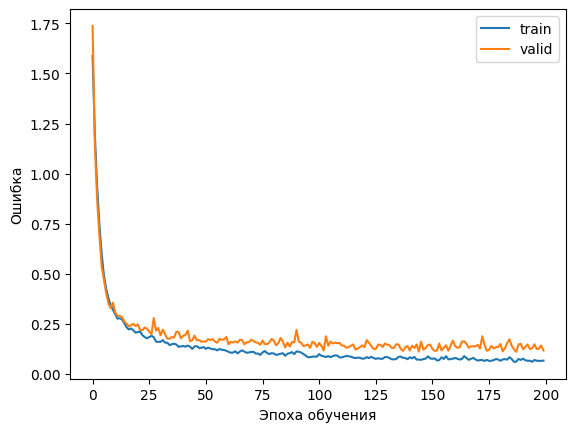

In [108]:
plt.plot(losses_FCNN_BN_32_4['train'], label='train');
plt.plot(losses_FCNN_BN_32_4['valid'], label='valid');
plt.legend();
plt.ylabel("Ошибка");
plt.xlabel("Эпоха обучения");

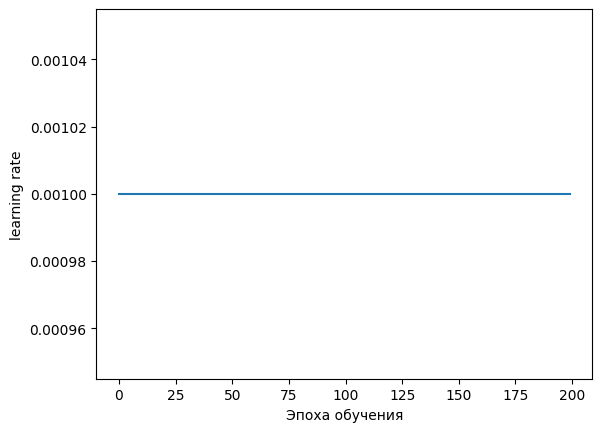

In [75]:
plt.plot(lr_FCNN_BN_32_4);
plt.ylabel("learning rate");
plt.xlabel("Эпоха обучения");

In [76]:
print('Loss в конце обучения')
print(f'На обучающей выборке: {losses_FCNN_BN_32_4["train"][-1]:.5f}')
print(f'На валидационной выборке: {losses_FCNN_BN_32_4["valid"][-1]:.5f}')

Loss в конце обучения
На обучающей выборке: 0.06567
На валидационной выборке: 0.11611


Посмотрим предсказания на нескольких случайных примерах.

In [77]:
some_indexes = y_test_resampled.groupby('target').sample(n=1, random_state=42).index
X_some_modes = X_test_resampled_scaled.loc[some_indexes]
y_some_modes = y_test_resampled.loc[some_indexes]

FCNN_BN_32_4.to("cpu")
FCNN_BN_32_4.eval()
logits = FCNN_BN_32_4(torch.tensor(X_some_modes.values, dtype=torch.float32))
predicted_classes = torch.argmax(logits, dim=1)

for target, predict in zip(y_some_modes.values, predicted_classes.detach().numpy()):
    print(f"Истина - {target[0]} >>> {encoder.inverse_transform([predict])[0]} - предсказание")

Истина - decreas_power_mode >>> decreas_power_mode - предсказание
Истина - full_power_mode >>> full_power_mode - предсказание
Истина - increas_power_mode >>> increas_power_mode - предсказание
Истина - partial_power_mode >>> partial_power_mode - предсказание
Истина - shutdown_mode >>> shutdown_mode - предсказание
Истина - start_up_mode >>> start_up_mode - предсказание
Истина - stopped_state_mode >>> stopped_state_mode - предсказание


Посмотрим на уверенность модели в своих предсказаниях.

In [78]:
pd.DataFrame(torch.softmax(logits, dim=1).detach().numpy(), columns=encoder.classes_).applymap(lambda x: f'{x:.3f}')

,decreas_power_mode,full_power_mode,increas_power_mode,partial_power_mode,shutdown_mode,start_up_mode,stopped_state_mode
0,1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,1.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.013,0.689,0.296,0.000,0.001,0.001
3,0.000,0.000,0.000,1.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.907,0.093,0.000
5,0.000,0.000,0.000,0.000,0.095,0.905,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,0.999


#### Анализ качества модели

In [79]:
FCNN_BN_32_4.eval()
logits =  FCNN_BN_32_4(
    torch.tensor(X_test_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_test_pred_FCNN_BN_32_4 = encoder.inverse_transform(predicted_classes)

**Матрица неточностей**

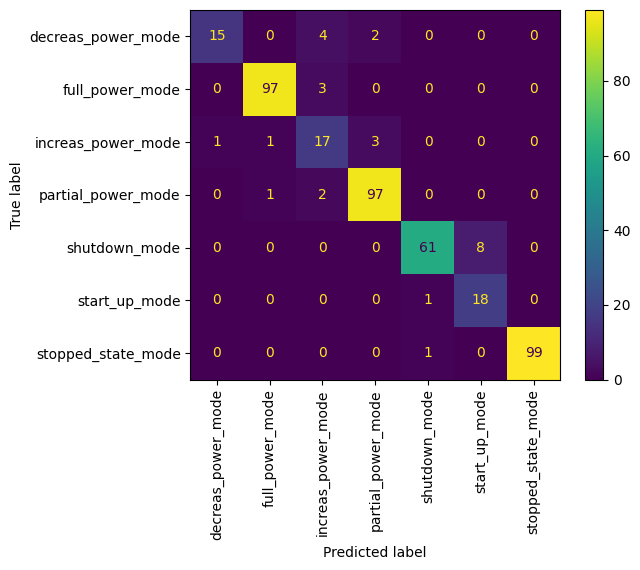

In [80]:
conf_mat = confusion_matrix(y_test_resampled, y_test_pred_FCNN_BN_32_4)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

**Accuracy**

In [81]:
accuracy_classifier['FCNN_BN_32_4'] = accuracy_score(y_test_resampled, y_test_pred_FCNN_BN_32_4)

**Precision и recall**

In [82]:
precision_classifier['FCNN_BN_32_4'] = precision_score(y_test_resampled, y_test_pred_FCNN_BN_32_4, average='macro', zero_division = np.nan)
recall_classifier['FCNN_BN_32_4'] = recall_score(y_test_resampled, y_test_pred_FCNN_BN_32_4, average='macro', zero_division = np.nan)

**F1**

In [83]:
f1_classifier['FCNN_BN_32_4'] = f1_score(y_test_resampled, y_test_pred_FCNN_BN_32_4, average='macro', zero_division = np.nan)

**Значения метрик**

In [84]:
print(f"accuracy - {accuracy_classifier['FCNN_BN_32_4']*100:0.2f}%")
print(f"precision - {precision_classifier['FCNN_BN_32_4']*100:0.2f}%")
print(f"recall - {recall_classifier['FCNN_BN_32_4']*100:0.2f}%")
print(f"F1 - {f1_classifier['FCNN_BN_32_4']*100:0.2f}%")

accuracy - 93.74%
precision - 88.32%
recall - 89.26%
F1 - 88.19%


### Модель №5

**Dropout**  

`Dropout` – это **регуляризация**, которая помогает **предотвратить переобучение** нейросетей, случайно **"отключая" нейроны** во время обучения.  

**Идея:**  
Во время обучения с **некоторой вероятностью (p)** нейроны временно отключаются (их выходы становятся нулями). Это заставляет модель **не зависеть слишком сильно от отдельных нейронов** и делать более **устойчивые обобщения**.  

---

### **Как работает Dropout?**
1. **Во время обучения:**  
   - Для каждого нейрона с вероятностью \( p \) зануляется его выход.  
   - Оставшиеся нейроны работают с увеличенной силой \( 1/(1-p) \), чтобы компенсировать потери.  

2. **Во время инференса (предсказаний):**  
   - Dropout **не применяется** – все нейроны работают нормально.  
   - Но так как во время обучения активные нейроны усиливались, их выход остается неизменным.  

In [85]:
class FCNN_BN_DO(nn.Module):
  def __init__(
      self, hidden_size=512, hidden_num=1,
      dropout_rate=0.5
      ):
    super(FCNN_BN_DO, self).__init__()

    # Входной слой
    self.input_layer = nn.Sequential(
        nn.Linear(INPUT_SIZE, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate)
    )

    # Скрытые слои
    self.hidden_layers = nn.ModuleList()
    for _ in range(hidden_num):
        self.hidden_layers.append(
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        )

    # Выходной слой
    self.output_layer = nn.Linear(hidden_size, OUTPUT_SIZE)

  def forward(self, x):
    x = self.input_layer(x)

    for layer in self.hidden_layers:
        x = layer(x)

    x = self.output_layer(x)
    return x

#### Обучение модели

In [86]:
FCNN_BN_DO_32_4 = FCNN_BN_DO(32, 4, 0.5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    FCNN_BN_DO_32_4.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=30, threshold=0.0001)

FCNN_BN_DO_32_4, losses_FCNN_BN_DO_32_4, lr_FCNN_BN_DO_32_4 = train_model(
    FCNN_BN_DO_32_4, criterion, optimizer,
    scheduler, num_epochs=200)

100%|██████████| 200/200 [00:45<00:00,  4.35it/s]


Посмотрим на график изменения среднего на эпохе значения функции потерь.

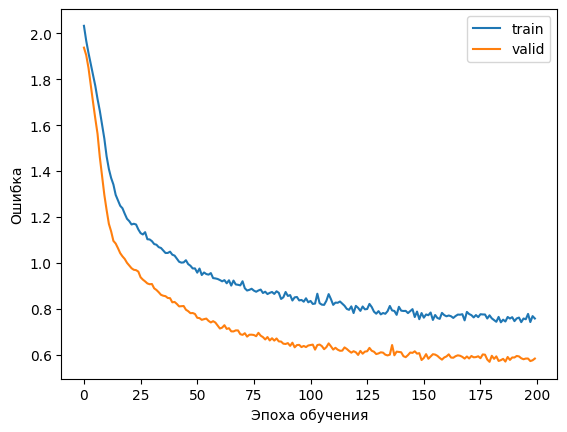

In [87]:
plt.plot(losses_FCNN_BN_DO_32_4['train'], label='train');
plt.plot(losses_FCNN_BN_DO_32_4['valid'], label='valid');
plt.legend();
plt.ylabel("Ошибка");
plt.xlabel("Эпоха обучения");

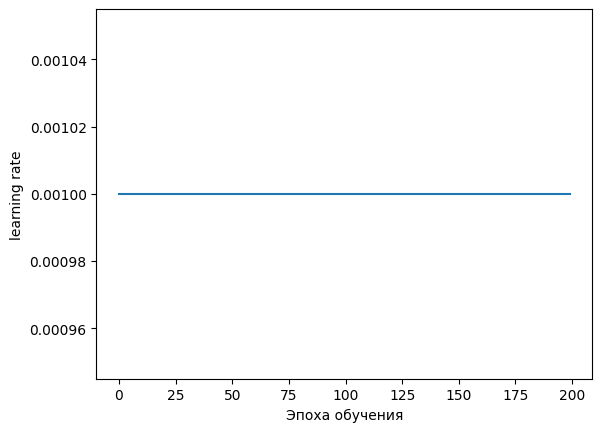

In [88]:
plt.plot(lr_FCNN_BN_DO_32_4);
plt.ylabel("learning rate");
plt.xlabel("Эпоха обучения");

In [89]:
print('Loss в конце обучения')
print(f'На обучающей выборке: {losses_FCNN_BN_DO_32_4["train"][-1]:.5f}')
print(f'На валидационной выборке: {losses_FCNN_BN_DO_32_4["valid"][-1]:.5f}')

Loss в конце обучения
На обучающей выборке: 0.75859
На валидационной выборке: 0.58429


Посмотрим предсказания на нескольких случайных примерах.

In [90]:
some_indexes = y_test_resampled.groupby('target').sample(n=1, random_state=42).index
X_some_modes = X_test_resampled_scaled.loc[some_indexes]
y_some_modes = y_test_resampled.loc[some_indexes]

FCNN_BN_DO_32_4.to("cpu")
FCNN_BN_DO_32_4.eval()
logits = FCNN_BN_DO_32_4(torch.tensor(X_some_modes.values, dtype=torch.float32))
predicted_classes = torch.argmax(logits, dim=1)

for target, predict in zip(y_some_modes.values, predicted_classes.detach().numpy()):
    print(f"Истина - {target[0]} >>> {encoder.inverse_transform([predict])[0]} - предсказание")

Истина - decreas_power_mode >>> full_power_mode - предсказание
Истина - full_power_mode >>> full_power_mode - предсказание
Истина - increas_power_mode >>> increas_power_mode - предсказание
Истина - partial_power_mode >>> partial_power_mode - предсказание
Истина - shutdown_mode >>> start_up_mode - предсказание
Истина - start_up_mode >>> start_up_mode - предсказание
Истина - stopped_state_mode >>> stopped_state_mode - предсказание


Посмотрим на уверенность модели в своих предсказаниях.

In [91]:
pd.DataFrame(torch.softmax(logits, dim=1).detach().numpy(), columns=encoder.classes_).applymap(lambda x: f'{x:.3f}')

,decreas_power_mode,full_power_mode,increas_power_mode,partial_power_mode,shutdown_mode,start_up_mode,stopped_state_mode
0,0.243,0.712,0.045,0.000,0.000,0.000,0.000
1,0.308,0.566,0.126,0.000,0.000,0.000,0.000
2,0.391,0.104,0.466,0.037,0.000,0.002,0.000
3,0.131,0.004,0.165,0.691,0.002,0.002,0.005
4,0.000,0.000,0.000,0.000,0.220,0.780,0.000
5,0.000,0.000,0.000,0.000,0.223,0.777,0.000
6,0.000,0.000,0.000,0.000,0.021,0.000,0.979


#### Анализ качества модели

In [92]:
FCNN_BN_DO_32_4.eval()
logits =  FCNN_BN_DO_32_4(
    torch.tensor(X_test_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_test_pred_FCNN_BN_DO_32_4 = encoder.inverse_transform(predicted_classes)

**Матрица неточностей**

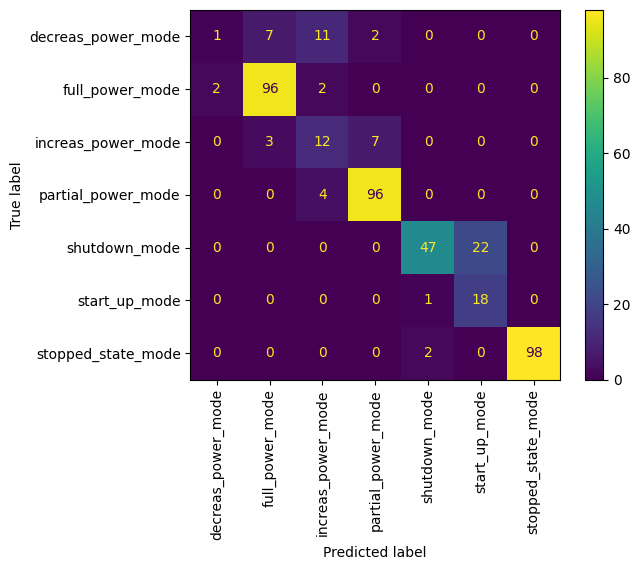

In [93]:
conf_mat = confusion_matrix(y_test_resampled, y_test_pred_FCNN_BN_DO_32_4)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

**Accuracy**

In [94]:
accuracy_classifier['FCNN_BN_DO_32_4'] = accuracy_score(
    y_test_resampled, y_test_pred_FCNN_BN_DO_32_4)

**Precision и recall**

In [95]:
precision_classifier['FCNN_BN_DO_32_4'] = precision_score(
    y_test_resampled, y_test_pred_FCNN_BN_DO_32_4,
    average='macro', zero_division = np.nan)
recall_classifier['FCNN_BN_DO_32_4'] = recall_score(
    y_test_resampled, y_test_pred_FCNN_BN_DO_32_4,
    average='macro', zero_division = np.nan)

**F1**

In [96]:
f1_classifier['FCNN_BN_DO_32_4'] = f1_score(
    y_test_resampled, y_test_pred_FCNN_BN_DO_32_4,
    average='macro', zero_division = np.nan)

**Значения метрик**

In [97]:
print(f"accuracy - {accuracy_classifier['FCNN_BN_DO_32_4']*100:0.2f}%")
print(f"precision - {precision_classifier['FCNN_BN_DO_32_4']*100:0.2f}%")
print(f"recall - {recall_classifier['FCNN_BN_DO_32_4']*100:0.2f}%")
print(f"F1 - {f1_classifier['FCNN_BN_DO_32_4']*100:0.2f}%")

accuracy - 85.38%
precision - 70.82%
recall - 73.17%
F1 - 68.75%


## Сравнение

In [98]:
df = pd.DataFrame(
    [precision_classifier, recall_classifier, f1_classifier, accuracy_classifier],
    index=['Precision', 'Recall', 'F1-score', 'Accuracy'])
df

,FCNN_16_2,FCNN_16_4,FCNN_32_4,FCNN_BN_32_4,FCNN_BN_DO_32_4
Precision,0.784129,0.772619,0.820423,0.883241,0.708153
Recall,0.814558,0.820935,0.869210,0.892634,0.731657
F1-score,0.795204,0.785900,0.835559,0.881947,0.687504
Accuracy,0.881671,0.874710,0.907193,0.937355,0.853828


## Какие сигналы оказывают самое сильное влияние на ответ модели?

**SHAP**  

SHAP (**SHapley Additive exPlanations**) – это метод интерпретации модели, который **показывает вклад каждого признака в предсказание**.  

---

**Что означают SHAP-значения?**
SHAP value показывает, **насколько каждый признак изменяет предсказание модели** относительно базового уровня (среднего предсказания).  

- **Отрицательные SHAP-значения** → Признак снижает вероятность предсказанного класса  
- **Положительные SHAP-значения** → Признак увеличивает вероятность предсказанного класса  
- **Чем больше по модулю SHAP value**, тем **важнее** этот признак для предсказания  

In [99]:
!pip install shap

PermutationExplainer explainer: 432it [00:39,  8.59it/s]                         


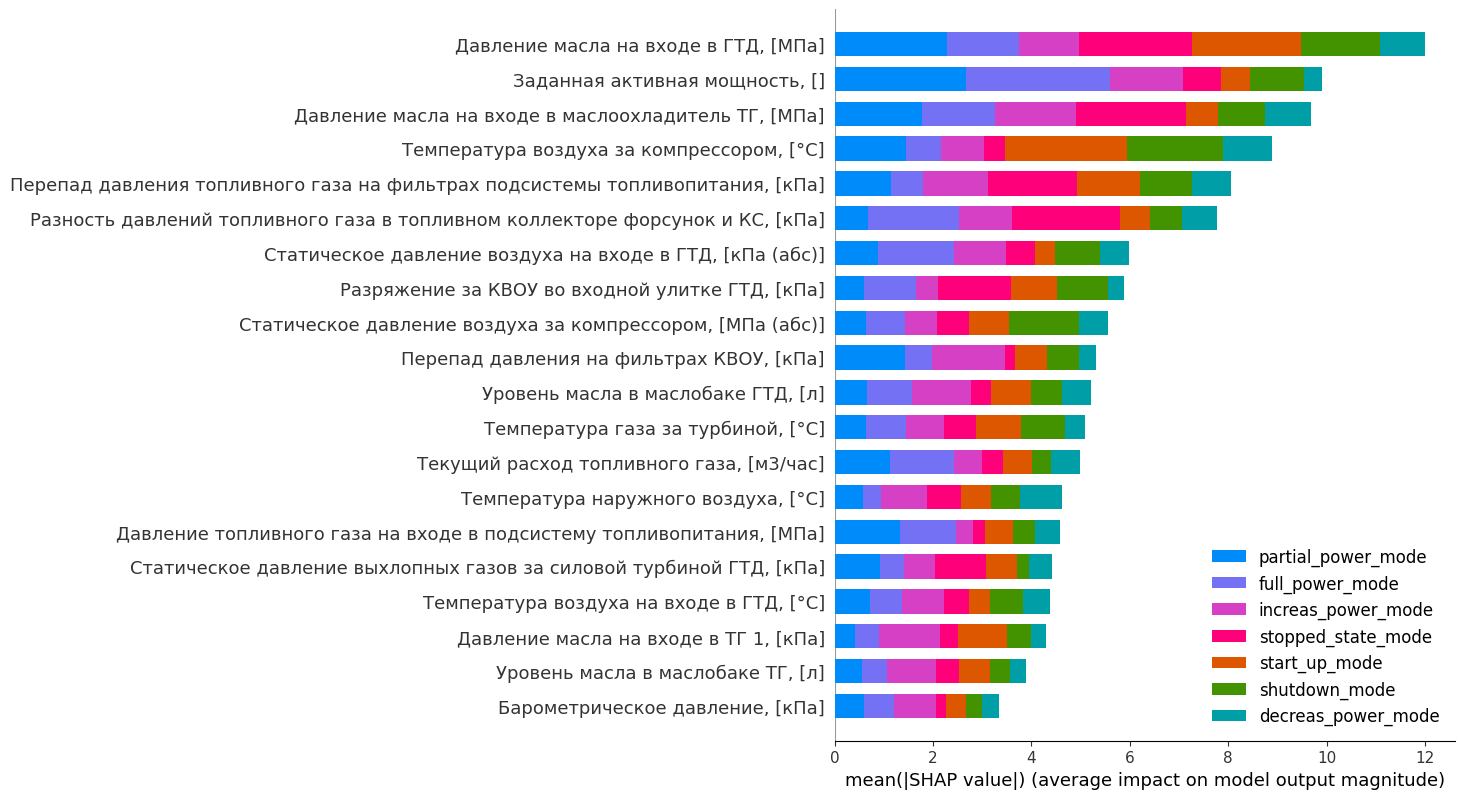

In [105]:
import shap

explainer = shap.Explainer(lambda x: FCNN_BN_32_4(
    torch.tensor(x.values, dtype=torch.float32)), X_train_resampled_scaled)
shap_values = explainer(X_test_resampled_scaled)

shap.summary_plot(shap_values,
                  X_test_resampled_scaled,
                  feature_names=[kks_to_description[kks] for kks in X_test_resampled_scaled.columns],
                  class_names=target_columns)